# JAX Automatic differentiation Playground

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/main/docs/notebooks/quickstart.ipynb)

**JAX is NumPy on the CPU, GPU, and TPU, with great automatic differentiation for high-performance machine learning research.**

With its updated version of [Autograd](https://github.com/hips/autograd), JAX
can automatically differentiate native Python and NumPy code. It can
differentiate through a large subset of Python’s features, including loops, ifs,
recursion, and closures, and it can even take derivatives of derivatives of
derivatives. It supports reverse-mode as well as forward-mode differentiation, and the two can be composed arbitrarily
to any order.

What’s new is that JAX uses
[XLA](https://www.tensorflow.org/xla)
to compile and run your NumPy code on accelerators, like GPUs and TPUs.
Compilation happens under the hood by default, with library calls getting
just-in-time compiled and executed. But JAX even lets you just-in-time compile
your own Python functions into XLA-optimized kernels using a one-function API.
Compilation and automatic differentiation can be composed arbitrarily, so you
can express sophisticated algorithms and get maximal performance without having
to leave Python.

In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

## Test 1:
Example of grad() use with basic function

In [3]:
def sum_logistic(x):
  return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x_small = jnp.arange(3.)
derivative_fn = grad(sum_logistic)
print(derivative_fn(x_small))

[0.25       0.19661197 0.10499357]


Let's verify with finite differences that our result is correct.

In [4]:
def first_finite_differences(f, x):
  eps = 1e-3
  return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)
                   for v in jnp.eye(len(x))])


print(first_finite_differences(sum_logistic, x_small))

[0.24998187 0.1965761  0.10502338]


Taking derivatives is as easy as calling {func}`~jax.grad`. {func}`~jax.grad` and {func}`~jax.jit` compose and can be mixed arbitrarily. In the above example we jitted `sum_logistic` and then took its derivative. We can go further:

In [5]:
print(grad(jit(grad(jit(grad(sum_logistic)))))(1.0))

-0.035325598


For more advanced autodiff, you can use {func}`jax.vjp` for reverse-mode vector-Jacobian products and {func}`jax.jvp` for forward-mode Jacobian-vector products. The two can be composed arbitrarily with one another, and with other JAX transformations. Here's one way to compose them to make a function that efficiently computes full Hessian matrices:

In [6]:
from jax import jacfwd, jacrev
def hessian(fun):
  return jit(jacfwd(jacrev(fun)))

## Test 2: 
This is closer to what we do in machine learning, using a loss function and some trainable weight

In [7]:
key = random.PRNGKey(0)

In [8]:
def sigmoid(x):
    return 0.5 * (jnp.tanh(x / 2) + 1)

# Outputs probability of a label being true.
def predict(W, b, inputs):
    return sigmoid(jnp.dot(inputs, W) + b)

# Build a toy dataset.
inputs = jnp.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])
targets = jnp.array([True, True, False, True])

# Training loss is the negative log-likelihood of the training examples.
def loss(W, b):
    preds = predict(W, b, inputs)
    label_probs = preds * targets + (1 - preds) * (1 - targets)
    return -jnp.sum(jnp.log(label_probs))

# Initialize random model coefficients
key, W_key, b_key = random.split(key, 3)
W = random.normal(W_key, (3,))
b = random.normal(b_key, ())

In [9]:
# Differentiate `loss` with respect to the first positional argument:
W_grad = grad(loss, argnums=0)(W, b)
print('W_grad', W_grad)

# Since argnums=0 is the default, this does the same thing:
W_grad = grad(loss)(W, b)
print('W_grad', W_grad)

# But we can choose different values too, and drop the keyword:
b_grad = grad(loss, 1)(W, b)
print('b_grad', b_grad)

# Including tuple values
W_grad, b_grad = grad(loss, (0, 1))(W, b)
print('W_grad', W_grad)
print('b_grad', b_grad)

W_grad [-0.16965583 -0.8774644  -1.4901346 ]
W_grad [-0.16965583 -0.8774644  -1.4901346 ]
b_grad -0.29227245
W_grad [-0.16965583 -0.8774644  -1.4901346 ]
b_grad -0.29227245


## Test 3: 
This is an example already with a tensor network. We're following the naive approach of making a loss function and feeding it an array that JAX knows how to operate, and only after that it's converted back to a TN. This way JAX can keep track of the operations that form the TN and differentiate over those. This means, however, that we're losing a lot of efficiency spent doing

*MPS -> dense tensor -> array --[JAX processes this as an arg in loss()]--> dense tensor -> MPS -> return value*

instead of 

*MPS -> loss() calculation -> return value*

In [10]:
import quimb.tensor as qtn
import numpy as np
from tqdm.auto import tqdm
import itertools
%config InlineBackend.figure_format = "svg"
from matplotlib import pyplot as plt
from functools import reduce

In [25]:
n = 8
chi = 256
chi_red = 10

In [26]:
psi_ref = qtn.MPS_rand_state(n, bond_dim=chi, normalize=True, tags=["ref"])
psi_ref.compress()
psi_ref

<MatrixProductState(tensors=8, indices=15, L=8, max_bond=16)>

In [27]:
psi_orig = qtn.MPS_rand_state(n, bond_dim=chi_red, normalize=True, tags=["approx"])
psi_orig.compress()
psi_orig

<MatrixProductState(tensors=8, indices=15, L=8, max_bond=10)>

In [28]:
fid = psi_ref.H & psi_orig ^ all
if fid < 0:
	psi_orig *= -1
	fid *= -1
fid

0.03314024553981158

In [29]:
# def fidelity(tensor:) -> float:

# def loss(f: float, norm: float) -> float:
# 	return (abs(f) - 1) ** 2  + (norm - 1) ** 2

# We need to define the loss function so that at least one of its arguments is what we want to differentiate on

def fidelity(psi1, psi2):
	# [psi1H, psi2] = qtn.tensor_network_align(psi1.H, psi2)
	# tn = (psi1H | psi2)
	# return tn ^ all
	return jnp.abs(psi1.H@psi2)

def norm(psi):
	return psi.H@psi

def loss_simple(fid,norm):
	return (abs(fid) - 1)**2 + (norm - 1)**2

def loss_array(psi_array,psi_shape,psi_ref):
	psi_tn = qtn.tensor_1d.MatrixProductState.from_dense(psi_array,psi_shape)
	return (abs(fidelity(psi_tn,psi_ref)) - 1)**2 + (norm(psi_tn) - 1)**2


In [30]:
# However, type MatrixProductState is not (obviously) a class recognized by JAX.
# We need to convert it to an array of arrays
def get_grad(psi,psi_ref,gradient=None):
    
    psi_dense = psi ^ all
    psi_array = psi_dense.data
    psi_shape = psi_array.shape

    if gradient is None:
        gradient = grad(loss_array,argnums=0)
    gradient_as_array = gradient(psi_array,psi_shape,psi_ref)
    # gradient_as_array = grad(loss_array, argnums=0)(psi_array,psi_shape,psi_ref)

    return qtn.tensor_1d.MatrixProductState.from_dense(gradient_as_array,psi_shape)


100%|██████████| 500/500 [03:31<00:00,  2.37it/s, fidelity=0.949, norm=1.01]               


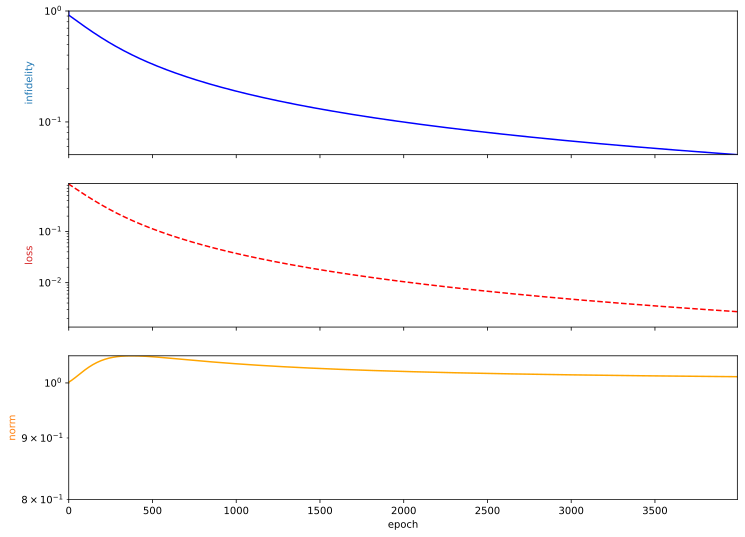

In [42]:
max_it = 500
alpha = 1
l_rate = 0.01

psi = psi_orig.copy(deep=True)
fid = psi_ref.H & psi ^ all
nrm = psi.norm()

gradient = grad(loss_array,argnums=0)

fig = plt.figure(figsize=(12,9))
[ax1, ax2, ax3] = fig.subplots(3,1, sharex=True)
ax3.set_xlabel("epoch")

ax1.set_ylabel("infidelity", color="tab:blue")
ax1.set_ylim(0, 1)
plot1, = ax1.semilogy([0], 1-fid, color="blue")

ax2.set_ylabel("loss", color="tab:red")
ax2.set_ylim(0, 1)
plot2, = ax2.semilogy([0], loss_simple(fid, nrm), color="red", linestyle="dashed")

ax3.set_ylabel("norm", color="tab:orange")
ax3.set_ylim(0, 2)
plot3, = ax3.semilogy([0], nrm, color="orange")

with tqdm(range(max_it)) as progressbar:
	progressbar.set_postfix(fidelity=f"{fidelity}")
	# progressbar.set_postfix(fidelity=f"{fid}")

	for it in progressbar:
		
		#compute gradient
		psi_grad = get_grad(psi,psi_ref,gradient)
		psi.add_MPS(psi_grad * - l_rate, inplace=True, compress=True)

		# recompute fidelity, norm
		fid = abs(psi_ref.H & psi ^ all)
		nrm = psi.norm()

		# update plot
		plot1.set_xdata(np.append(plot1.get_xdata(), psi.nsites * it))
		plot1.set_ydata(np.append(plot1.get_ydata(), 1-fid))
		plot2.set_xdata(np.append(plot2.get_xdata(), psi.nsites * it))
		plot2.set_ydata(np.append(plot2.get_ydata(), loss_simple(fid, nrm)))
		plot3.set_xdata(np.append(plot3.get_xdata(), psi.nsites * it))
		plot3.set_ydata(np.append(plot3.get_ydata(), nrm))

		progressbar.set_postfix(fidelity=fid, norm=nrm)

ax1.set_xlim(0, it)
ax1.set_ylim(min(plot1.get_ydata()), 1)
ax2.set_ylim(min(plot2.get_ydata()) / 2, max(plot2.get_ydata()))
ax3.set_ylim(0.8, max(plot3.get_ydata()))

plt.show()

Despite being a bit slower, it converges!

## Test 4:

We want to gain efficiency by using JAX integrations in QUIMB. This way, grad will be handled by quimb further down the pipeline without needing to artifically break the TN structure.

In [24]:
# Approach 1: Let the optimize algorithm do all the work

import quimb as qu
import quimb.tensor as qtn
from autoray import do
import functools
import numpy as np

# reinitialize the samples
n = 16
chi_real = 256
chi_approx = 40
psi_ref = qtn.MPS_rand_state(n, bond_dim=chi_real, normalize=True, tags=["ref"])
psi_ref.compress()
psi_orig = qtn.MPS_rand_state(n, bond_dim=chi_approx, normalize=True, tags=["approx"])
psi_orig.compress()
print(np.abs(fidelity(psi_orig,psi_ref)))
# function that takes the input TN and computes the loss
def loss(psi, psi_ref):
    return (abs(fidelity(psi,psi_ref)) - 1)**2 + (norm(psi) - 1)**2

# If loss function is a sum of smaller loss functions (as is the case with the average over n samples) we can evaluate them separately (yay, parallelism!)
# This means we need to make a list of functions. This example abstracts how it would look like for the TNAD example.
# loss_fid(P,samples)
# loss_fns = [
#     functools.partial(loss_fid, samples=sample)
#     for sample in samples
# ] + [ loss_norm ]

# in loss constants we can specify which parameters we do not want to differentiate over.
tnopt = qtn.TNOptimizer(
    psi_orig,
    loss_fn=loss,
    loss_constants={'psi_ref': psi_ref},
    autodiff_backend='jax',
)

psi_final = tnopt.optimize(2000, tol=1e-13)
# -1.9249370098114014: 100%|██████████| 100/100 [00:32<00:00,  3.05it/s]
# <TensorNetwork1DVector(tensors=58, indices=70, L=5, max_bond=2)>

# psi_final = tnopt.get_tn_opt()
print(f"infidelity = {1-np.abs(fidelity(psi_final,psi_ref))}")
print(f"norm = {norm(psi_final)}")

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0011003128


+0.039366483688 [best: +0.039366483688] :  93%|█████████▎| 1865/2000 [00:27<00:01, 68.60it/s] 


infidelity = 0.18542605638504028
norm = 1.0705968141555786


Approach 2: Use integrated methods only for gradient extraction and do the optimization by hand
(not working at the moment)

100%|██████████| 500/500 [15:26<00:00,  1.85s/it, fidelity=0.7026006, norm=1.1]            


(0.8, 1.1114276441493924)

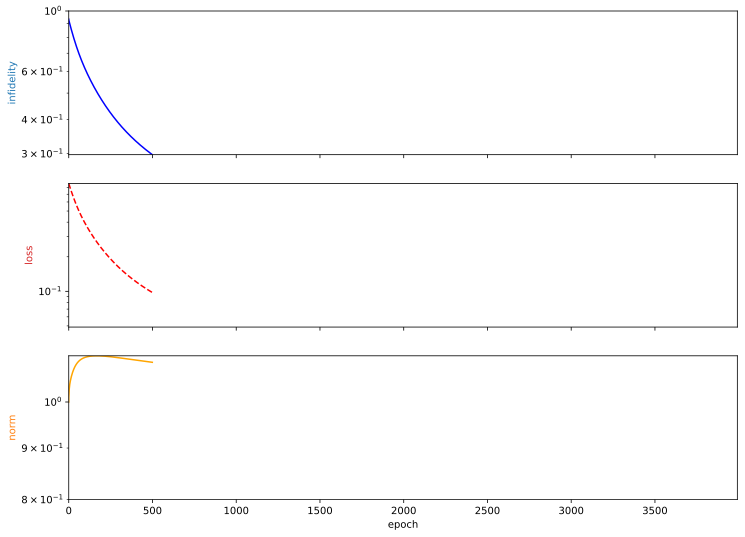

In [41]:
# Approach 2: Use integrated methods only for gradient extraction and do the optimization by hand

import quimb as qu
import quimb.tensor as qtn
from autoray import do
import functools
import numpy as np

# reinitialize the samples
n = 8
chi_real = 256
chi_approx = 10
psi_ref = qtn.MPS_rand_state(n, bond_dim=chi_real, normalize=True, tags=["ref"])
psi_ref.compress()
psi_orig = qtn.MPS_rand_state(n, bond_dim=chi_approx, normalize=True, tags=["approx"])
psi_orig.compress()

fid = np.abs(fidelity(psi_orig,psi_ref))
nrm = norm(psi_orig)
# function that takes the input TN and computes the loss
def loss(psi, psi_ref):
    return (abs(fidelity(psi,psi_ref)) - 1)**2 + (norm(psi) - 1)**2

l_rate = 0.01
max_it = 500
losses = []
psi = psi_orig.copy(deep=True)

fig = plt.figure(figsize=(12,9))
[ax1,ax2,ax3] = fig.subplots(3,1, sharex=True)
ax3.set_xlabel("epoch")

ax1.set_ylabel("infidelity", color="tab:blue")
ax1.set_ylim(0, 1)
plot1, = ax1.semilogy([0], 1-fid, color="blue")

ax2.set_ylabel("loss", color="tab:red")
ax2.set_ylim(0, 1)
plot2, = ax2.semilogy([0], loss_simple(fid, nrm), color="red", linestyle="dashed")

ax3.set_ylabel("norm", color="tab:orange")
ax3.set_ylim(0, 2)
plot3, = ax3.semilogy([0], nrm, color="orange")



with tqdm(range(max_it)) as progressbar:
	progressbar.set_postfix(fidelity=f"{fidelity}")
	# progressbar.set_postfix(fidelity=f"{fid}")

	for it in progressbar:
		tnopt = qtn.TNOptimizer(
			psi,
			loss_fn=loss,
			loss_constants={'psi_ref': psi_ref},
			autodiff_backend='jax',
		)

		x = tnopt.vectorizer.vector 
		loss_v, grad_full = tnopt.vectorized_value_and_grad(x)
		tnopt.vectorizer.vector[:] = grad_full
		grad_tn = tnopt.get_tn_opt()

		# grad_tn = tnopt.vectorizer.unpack(grad_full)[0]

		for tensor in range(psi.nsites):
			site_tag = psi.site_tag(tensor)
			tensor_orig = psi.select_tensors(site_tag, which="any")[0]
			tensor_orig.modify(data = tensor_orig.data - l_rate*grad_tn[tensor].transpose_like(tensor_orig).data) 

		# psi.add_MPS(grad_tn * - l_rate, inplace=True, compress=True)

		# losses.append(loss)

		# recompute fidelity, norm
		fid = fidelity(psi,psi_ref)
		nrm = norm(psi)
		# fid = abs(psi_ref.H & psi ^ all)
		# nrm = psi.norm()

		# update plot
		plot1.set_xdata(np.append(plot1.get_xdata(), it))
		plot1.set_ydata(np.append(plot1.get_ydata(), 1-fid))
		plot2.set_xdata(np.append(plot2.get_xdata(), it))
		plot2.set_ydata(np.append(plot2.get_ydata(), loss_v))
		plot3.set_xdata(np.append(plot3.get_xdata(), it))
		plot3.set_ydata(np.append(plot3.get_ydata(), nrm))

		progressbar.set_postfix(fidelity=fid, norm=nrm)

ax1.set_xlim(0, it)
ax1.set_ylim(min(plot1.get_ydata()), 1)
ax2.set_ylim(min(plot2.get_ydata()) / 2, max(plot2.get_ydata()))
ax3.set_ylim(0.8, max(plot3.get_ydata()))

# print(f"infidelity = {1-np.abs(fidelity(psi,psi_ref))}")
# print(f"norm = {norm(psi)}")


100%|██████████| 150/150 [02:35<00:00,  1.03s/it, fidelity=0.545416, norm=1.11]            


(0.8, 1.1151214982224893)

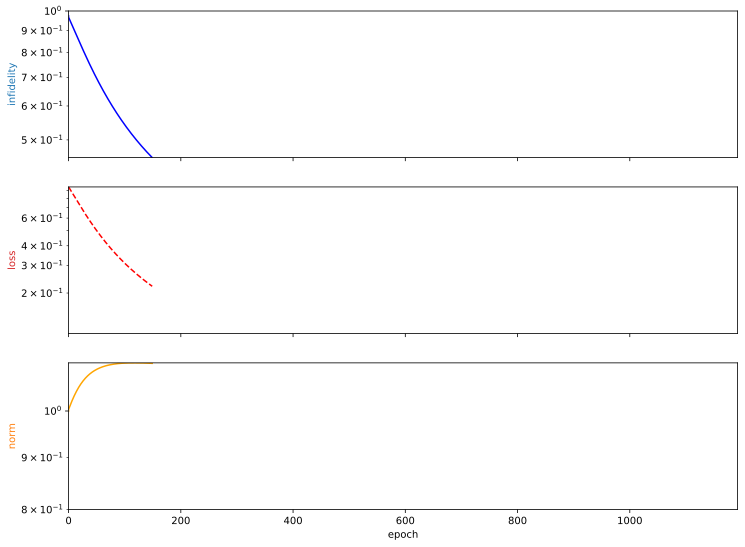

In [33]:
# Approach 2: Use integrated methods only for gradient extraction and do the optimization by hand

import quimb as qu
import quimb.tensor as qtn
from autoray import do
import functools
import numpy as np

# reinitialize the samples
n = 8
chi_real = 512
chi_approx = 100
psi_ref = qtn.MPS_rand_state(n, bond_dim=chi_real, normalize=True, tags=["ref"])
psi_ref.compress()
psi_orig = qtn.MPS_rand_state(n, bond_dim=chi_approx, normalize=True, tags=["approx"])
psi_orig.compress()

fid = np.abs(fidelity(psi_orig,psi_ref))
nrm = norm(psi_orig)
# function that takes the input TN and computes the loss
def loss(psi, psi_ref):
    return (abs(fidelity(psi,psi_ref)) - 1)**2 + (norm(psi) - 1)**2

l_rate = 0.01
max_it = 150
losses = []
psi = psi_orig.copy(deep=True)

fig = plt.figure(figsize=(12,9))
[ax1,ax2,ax3] = fig.subplots(3,1, sharex=True)
ax3.set_xlabel("epoch")

ax1.set_ylabel("infidelity", color="tab:blue")
ax1.set_ylim(0, 1)
plot1, = ax1.semilogy([0], 1-fid, color="blue")

ax2.set_ylabel("loss", color="tab:red")
ax2.set_ylim(0, 1)
plot2, = ax2.semilogy([0], loss_simple(fid, nrm), color="red", linestyle="dashed")

ax3.set_ylabel("norm", color="tab:orange")
ax3.set_ylim(0, 2)
plot3, = ax3.semilogy([0], nrm, color="orange")



with tqdm(range(max_it)) as progressbar:
	progressbar.set_postfix(fidelity=f"{fidelity}")
	# progressbar.set_postfix(fidelity=f"{fid}")

	for it in progressbar:
		tnopt = qtn.TNOptimizer(
			psi,
			loss_fn=loss,
			loss_constants={'psi_ref': psi_ref},
			autodiff_backend='jax',
		)

		x = tnopt.vectorizer.vector 
		loss_v, grad_full = tnopt.vectorized_value_and_grad(x)
		tnopt.vectorizer.vector[:] = grad_full
		grad_tn = tnopt.get_tn_opt()
		
		for tensor in range(psi.nsites):
			site_tag = psi.site_tag(tensor)
			tensor_orig = psi.select_tensors(site_tag, which="any")[0]
			tensor_orig.modify(data = tensor_orig.data - l_rate*grad_tn[tensor].transpose_like(tensor_orig).data) 

		# losses.append(loss)

		# recompute fidelity, norm
		fid = fidelity(psi,psi_ref)
		nrm = norm(psi)

		# update plot
		plot1.set_xdata(np.append(plot1.get_xdata(), it))
		plot1.set_ydata(np.append(plot1.get_ydata(), 1-fid))
		plot2.set_xdata(np.append(plot2.get_xdata(), it))
		plot2.set_ydata(np.append(plot2.get_ydata(), loss_v))
		plot3.set_xdata(np.append(plot3.get_xdata(), it))
		plot3.set_ydata(np.append(plot3.get_ydata(), nrm))

		progressbar.set_postfix(fidelity=fid, norm=nrm)

ax1.set_xlim(0, it)
ax1.set_ylim(min(plot1.get_ydata()), 1)
ax2.set_ylim(min(plot2.get_ydata()) / 2, max(plot2.get_ydata()))
ax3.set_ylim(0.8, max(plot3.get_ydata()))

# print(f"infidelity = {1-np.abs(fidelity(psi,psi_ref))}")
# print(f"norm = {norm(psi)}")


In [17]:
plt.show()

## Test 5: Using dask and other optimizers

In [18]:
from dask.distributed import Client, LocalCluster

# client = Client()
client = Client(n_workers=12)
client # Displays the information of the local client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 12,Total memory: 15.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61326,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.73 GiB
Comm: tcp://127.0.0.1:61398,Total threads: 1
Dashboard: http://127.0.0.1:61399/status,Memory: 1.31 GiB
Nanny: tcp://127.0.0.1:61338,


In [19]:
# Approach 1: Let the optimize algorithm do all the work

import quimb as qu
import quimb.tensor as qtn
from autoray import do
import functools
import numpy as np

# reinitialize the samples
n = 16
chi_real = 512 # for 16 sites the limit is 256 anyway
chi_approx = 40
psi_ref = qtn.MPS_rand_state(n, bond_dim=chi_real, normalize=True, tags=["ref"])
psi_ref.compress()
psi_orig = qtn.MPS_rand_state(n, bond_dim=chi_approx, normalize=True, tags=["approx"])
psi_orig.compress()
print(np.abs(fidelity(psi_orig,psi_ref)))
# function that takes the input TN and computes the loss
def loss(psi, psi_ref):
    return (abs(fidelity(psi,psi_ref)) - 1)**2 + (norm(psi) - 1)**2

# If loss function is a sum of smaller loss functions (as is the case with the average over n samples) we can evaluate them separately (yay, parallelism!)
# This means we need to make a list of functions. This example abstracts how it would look like for the TNAD example.
# loss_fid(P,samples)
# loss_fns = [
#     functools.partial(loss_fid, samples=sample)
#     for sample in samples
# ] + [ loss_norm ]

# in loss constants we can specify which parameters we do not want to differentiate over.
tnopt = qtn.TNOptimizer(
    psi_orig,
    loss_fn=loss,
    loss_constants={'psi_ref': psi_ref},
    autodiff_backend='jax',
    # optimizer='adam',
    jit_fn = True,
    executor=client,
)

psi_final = tnopt.optimize(2000, tol=1e-13)
# -1.9249370098114014: 100%|██████████| 100/100 [00:32<00:00,  3.05it/s]
# <TensorNetwork1DVector(tensors=58, indices=70, L=5, max_bond=2)>

# psi_final = tnopt.get_tn_opt()
print(f"infidelity = {1-np.abs(fidelity(psi_final,psi_ref))}")
print(f"norm = {norm(psi_final)}")

  0%|          | 0/2000 [00:00<?, ?it/s]

0.004319156


+0.084580585361 [best: +0.084580585361] : : 2041it [00:30, 66.28it/s]                         


infidelity = 0.27607524394989014
norm = 1.091451644897461


In [20]:
# Approach 1: Let the optimize algorithm do all the work

import quimb as qu
import quimb.tensor as qtn
from autoray import do
import functools
import numpy as np

# reinitialize the samples
n = 16
chi_real = 512
chi_approx = 40
psi_ref = qtn.MPS_rand_state(n, bond_dim=chi_real, normalize=True, tags=["ref"])
psi_ref.compress()
psi_orig = qtn.MPS_rand_state(n, bond_dim=chi_approx, normalize=True, tags=["approx"])
psi_orig.compress()
print(np.abs(fidelity(psi_orig,psi_ref)))
# function that takes the input TN and computes the loss
def loss(psi, psi_ref):
    return (abs(fidelity(psi,psi_ref)) - 1)**2 + (norm(psi) - 1)**2

# If loss function is a sum of smaller loss functions (as is the case with the average over n samples) we can evaluate them separately (yay, parallelism!)
# This means we need to make a list of functions. This example abstracts how it would look like for the TNAD example.
# loss_fid(P,samples)
# loss_fns = [
#     functools.partial(loss_fid, samples=sample)
#     for sample in samples
# ] + [ loss_norm ]

# in loss constants we can specify which parameters we do not want to differentiate over.
tnopt = qtn.TNOptimizer(
    psi_orig,
    loss_fn=loss,
    loss_constants={'psi_ref': psi_ref},
    autodiff_backend='jax',
    optimizer='adam',
    jit_fn = False,
    executor=client,
)

psi_final = tnopt.optimize(2000, tol=1e-13)
# -1.9249370098114014: 100%|██████████| 100/100 [00:32<00:00,  3.05it/s]
# <TensorNetwork1DVector(tensors=58, indices=70, L=5, max_bond=2)>

# psi_final = tnopt.get_tn_opt()
print(f"infidelity = {1-np.abs(fidelity(psi_final,psi_ref))}")
print(f"norm = {norm(psi_final)}")

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00018895356


+0.038952995092 [best: +0.038830768317] : : 2001it [07:27,  4.47it/s]                        

infidelity = 0.18806248903274536
norm = 1.059877634048462


In [22]:
# Approach 1: Let the optimize algorithm do all the work

import quimb as qu
import quimb.tensor as qtn
from autoray import do
import functools
import numpy as np

# reinitialize the samples
n = 16
chi_real = 512
chi_approx = 40
psi_ref = qtn.MPS_rand_state(n, bond_dim=chi_real, normalize=True, tags=["ref"])
psi_ref.compress()
psi_orig = qtn.MPS_rand_state(n, bond_dim=chi_approx, normalize=True, tags=["approx"])
psi_orig.compress()
print(np.abs(fidelity(psi_orig,psi_ref)))
# function that takes the input TN and computes the loss
def loss(psi, psi_ref):
    return (abs(fidelity(psi,psi_ref)) - 1)**2 + (norm(psi) - 1)**2

# If loss function is a sum of smaller loss functions (as is the case with the average over n samples) we can evaluate them separately (yay, parallelism!)
# This means we need to make a list of functions. This example abstracts how it would look like for the TNAD example.
# loss_fid(P,samples)
# loss_fns = [
#     functools.partial(loss_fid, samples=sample)
#     for sample in samples
# ] + [ loss_norm ]

# in loss constants we can specify which parameters we do not want to differentiate over.
tnopt = qtn.TNOptimizer(
    psi_orig,
    loss_fn=loss,
    loss_constants={'psi_ref': psi_ref},
    autodiff_backend='jax',
    optimizer='sgd',
    jit_fn = False,
    executor=client,
)

psi_final = tnopt.optimize(2000, tol=1e-13)
# -1.9249370098114014: 100%|██████████| 100/100 [00:32<00:00,  3.05it/s]
# <TensorNetwork1DVector(tensors=58, indices=70, L=5, max_bond=2)>

# psi_final = tnopt.get_tn_opt()
print(f"infidelity = {1-np.abs(fidelity(psi_final,psi_ref))}")
print(f"norm = {norm(psi_final)}")

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0030324997


+0.167228654027 [best: +0.167228654027] : : 2001it [05:53,  5.67it/s]                        

infidelity = 0.39448869228363037
norm = 1.1077377796173096
